(1160, 6)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


['St', 'John', 'of', 'the', 'Cross', 'testifies', 'to', 'a', 'God', 'who', 'longs', 'to', 'meet', 'us', 'in', 'our', 'deepest', 'need', '.', 'Whilst', 'rejection', 'and', 'imprisonment', 'played', 'their', 'part', 'in', 'the', 'life', 'of', 'this', 'sixteenth-century', 'Spanish', 'friar', ',', 'John', "'s", 'poetry', 'and', 'prose', 'reveal', 'the', 'beauty', 'and', 'power', 'of', 'a', 'wondrous', 'God', '.', 'It', 'gives', 'us', 'courage', 'to', 'believe', 'in', 'the', 'possibility', 'of', 'change', 'in', 'our', 'own', 'lives', ',', 'however', 'unlikely', 'or', 'impossible', 'this', 'may', 'seem.', '<', 'br', '/', '>', 'Father', 'Iain', 'Matthew', 'uses', 'this', 'classic', 'inspirational', 'Christian', 'writing', 'as', 'his', 'starting', 'point', ',', 'and', 'offers', 'five', 'interpretations', 'which', 'make', 'its', 'richness', 'relevant', 'to', 'the', 'modern', 'reader', '.']
[('St', 'NNP'), ('John', 'NNP'), ('of', 'IN'), ('the', 'DT'), ('Cross', 'NNP'), ('testifies', 'NNS'), ('to

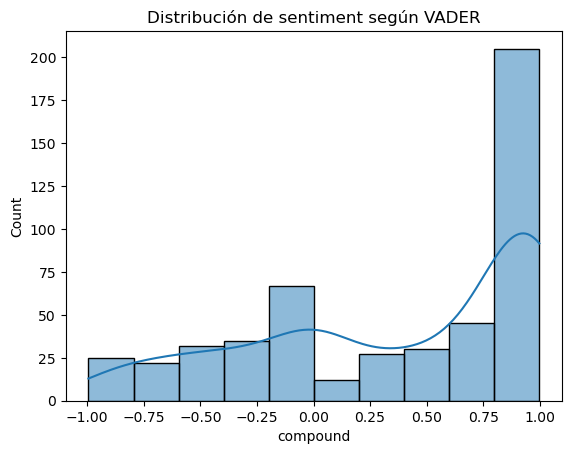

Device set to use cpu


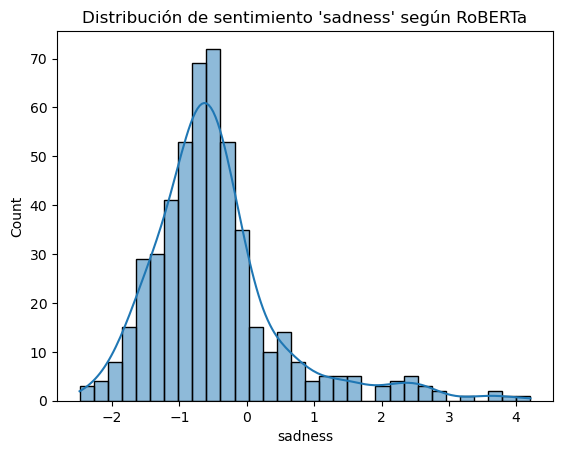

In [1]:
# %% [markdown]
# # NLP: Sentiment Analysis with VADER and RoBERTa
# Análisis de sentimientos usando VADER y RoBERTa en descripciones de libros

# %%
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# %%
# Cargar CSV
file_path = "../../data/processed/books.csv"
df = pd.read_csv(file_path)

# %%
# Limpieza de nombres de columnas
df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace(".", "_").str.replace(":", "")

# %%
# Vista previa del dataset
print(df.shape)
df.head()

# %%
# Seleccionar columnas de interés
df = df[["blurb", "tags", "book_title"]].dropna(subset=["blurb"])
df = df.head(500)  # Subset para prototipado

# %% [markdown]
# ## NLP Preprocessing: Tokenización con NLTK

# %%
import nltk
from nltk.tokenize import PunktSentenceTokenizer, TreebankWordTokenizer

# Descargar todos los recursos necesarios
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("vader_lexicon")

# Tokenizers alternativos (evitan bug de word_tokenize)
tokenizer_sent = PunktSentenceTokenizer()
tokenizer_words = TreebankWordTokenizer()

# Tokenización de ejemplo
example = df["blurb"].iloc[65]
sentences = tokenizer_sent.tokenize(example)
tokens = []
for sentence in sentences:
    tokens.extend(tokenizer_words.tokenize(sentence))

print(tokens)

# Etiquetado gramatical (POS tagging)
print(nltk.pos_tag(tokens))


# %% [markdown]
# ## Sentiment Analysis: VADER

# %%
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# %%
# Aplicar VADER
pol_scores = {}
for i, row in df.iterrows():
    text = row["blurb"]
    scores = sia.polarity_scores(text)
    pol_scores[i] = scores

# %%
# Combinar resultados
vaders = pd.DataFrame(pol_scores).T
vaders = pd.concat([df.reset_index(drop=True), vaders.reset_index(drop=True)], axis=1)

# %%
# Visualización
sns.histplot(vaders["compound"], kde=True)
plt.title("Distribución de sentiment según VADER")
plt.show()

# %% [markdown]
# ## Sentiment Analysis: RoBERTa

# %%
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch

# Cargar modelo preentrenado (puede cambiarse por uno en español si se desea)
MODEL = "j-hartmann/emotion-english-distilroberta-base"
classifier = pipeline("text-classification", model=MODEL, return_all_scores=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# %%
# Función para aplicar modelo RoBERTa
def mooder(text):
    max_len = 512
    encoded_text = tokenizer(text, return_tensors="pt", max_length=max_len, truncation=True, padding="max_length")
    with torch.no_grad():
        output = model(**encoded_text)
    scores = output.logits[0].numpy()
    moods = {
        "anger": scores[0],
        "disgust" : scores[1],
        "fear": scores[2],
        "joy": scores[3],
        "neutral": scores[4], 
        "sadness": scores[5],
        "surprise": scores[6]
    }
    return moods

# %%
# Aplicar a todos los registros
roberta = df["blurb"].apply(mooder)
roberta_df = pd.DataFrame(roberta.tolist())

# %%
# Unir con dataset original
moods = pd.concat([df.reset_index(drop=True), roberta_df.reset_index(drop=True)], axis=1)

# %%
# Vista previa
moods.sample(10)

# %%
# Libros con mayor disgusto
moods.sort_values(by="disgust", ascending=False).head(10)

# %%
# Visualizar tristeza
sns.histplot(moods["sadness"], kde=True)
plt.title("Distribución de sentimiento 'sadness' según RoBERTa")
plt.show()
